### Imports

In [2]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import time
import os
import aux_tools as aux

### Dataframe

In [3]:
fases_txt = './CP_fases.txt'
fases_txt = os.path.abspath(fases_txt)
mina = np.loadtxt(fases_txt, skiprows=1, delimiter=' ')
# Columnas
#0: x 
#1: y 
#2: z
#3: au
#4: cpy 
#5: cueq
#6: cus
#7: cut
#8: density 
#9: material
#10: py
#11: recg_au
#12: recg_cu
#13: tasox
#14: tipomineral
#15: fase
#16: 0
# --- CÓDIGO PARA CREAR EL DATAFRAME ---

# 1. Define los índices de las columnas que quieres extraer
indices_columnas = [
    0,  # Índice para 'x'
    1,  # Índice para 'y'
    2,  # Índice para 'z'
    15, # Índice para 'fase'
    9,   # Índice para 'material'
    14, #tipomineral
    8, #densidad
    7, #cut / ley?
    16 # ID
]

# 2. Define los nombres que quieres dar a esas columnas en el DataFrame
nombres_nuevas_columnas = [
    'x',
    'y',
    'z',
    'fase',
    'material',
    'tipo_material',
    'densidad',
    'ley',
    'ID'
]

# 3. Selecciona las columnas del array 'mina' usando los índices
datos_seleccionados = mina[:, indices_columnas]

# 4. Crea el DataFrame de pandas
df_mina = pd.DataFrame(data=datos_seleccionados, columns=nombres_nuevas_columnas)

# 5. (Opcional) Muestra las primeras filas del DataFrame para verificar
print("DataFrame creado:")
print(df_mina.head())

# 6. (Opcional) Muestra información sobre el DataFrame (tipos de datos, etc.)
print("\nInformación del DataFrame:")
df_mina.info()

combinaciones = (
    df_mina[['fase', 'z']]
    .drop_duplicates()
    .sort_values(['fase', 'z'], ascending=[True, False])
)

# Asignar número de banco por grupo de fase
combinaciones['banco'] = (
    combinaciones.groupby('fase').cumcount() + 1
)

# Unir esta info de vuelta al df original
df_mina = df_mina.merge(combinaciones, on=['fase', 'z'], how='left')

DataFrame creado:
          x          y       z  fase  material  tipo_material  densidad  \
0  491425.0  7456205.0  1968.0   4.0       8.0            2.0  2.615598   
1  491435.0  7456195.0  1968.0   4.0       8.0            2.0  2.626056   
2  491445.0  7456195.0  1968.0   4.0       6.0            2.0  2.637350   
3  491455.0  7456195.0  1968.0   4.0       6.0            2.0  2.637350   
4  491435.0  7456205.0  1968.0   4.0       8.0            2.0  2.615598   

        ley   ID  
0  0.550661  1.0  
1  0.491924  2.0  
2  0.396348  3.0  
3  0.396348  4.0  
4  0.550661  5.0  

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91282 entries, 0 to 91281
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              91282 non-null  float64
 1   y              91282 non-null  float64
 2   z              91282 non-null  float64
 3   fase           91282 non-null  float64
 4   material    

## Funciones

### Graficar

Ejemplo de los graficos

Tratando 'tipo_material' como Categórica (4 valores únicos).


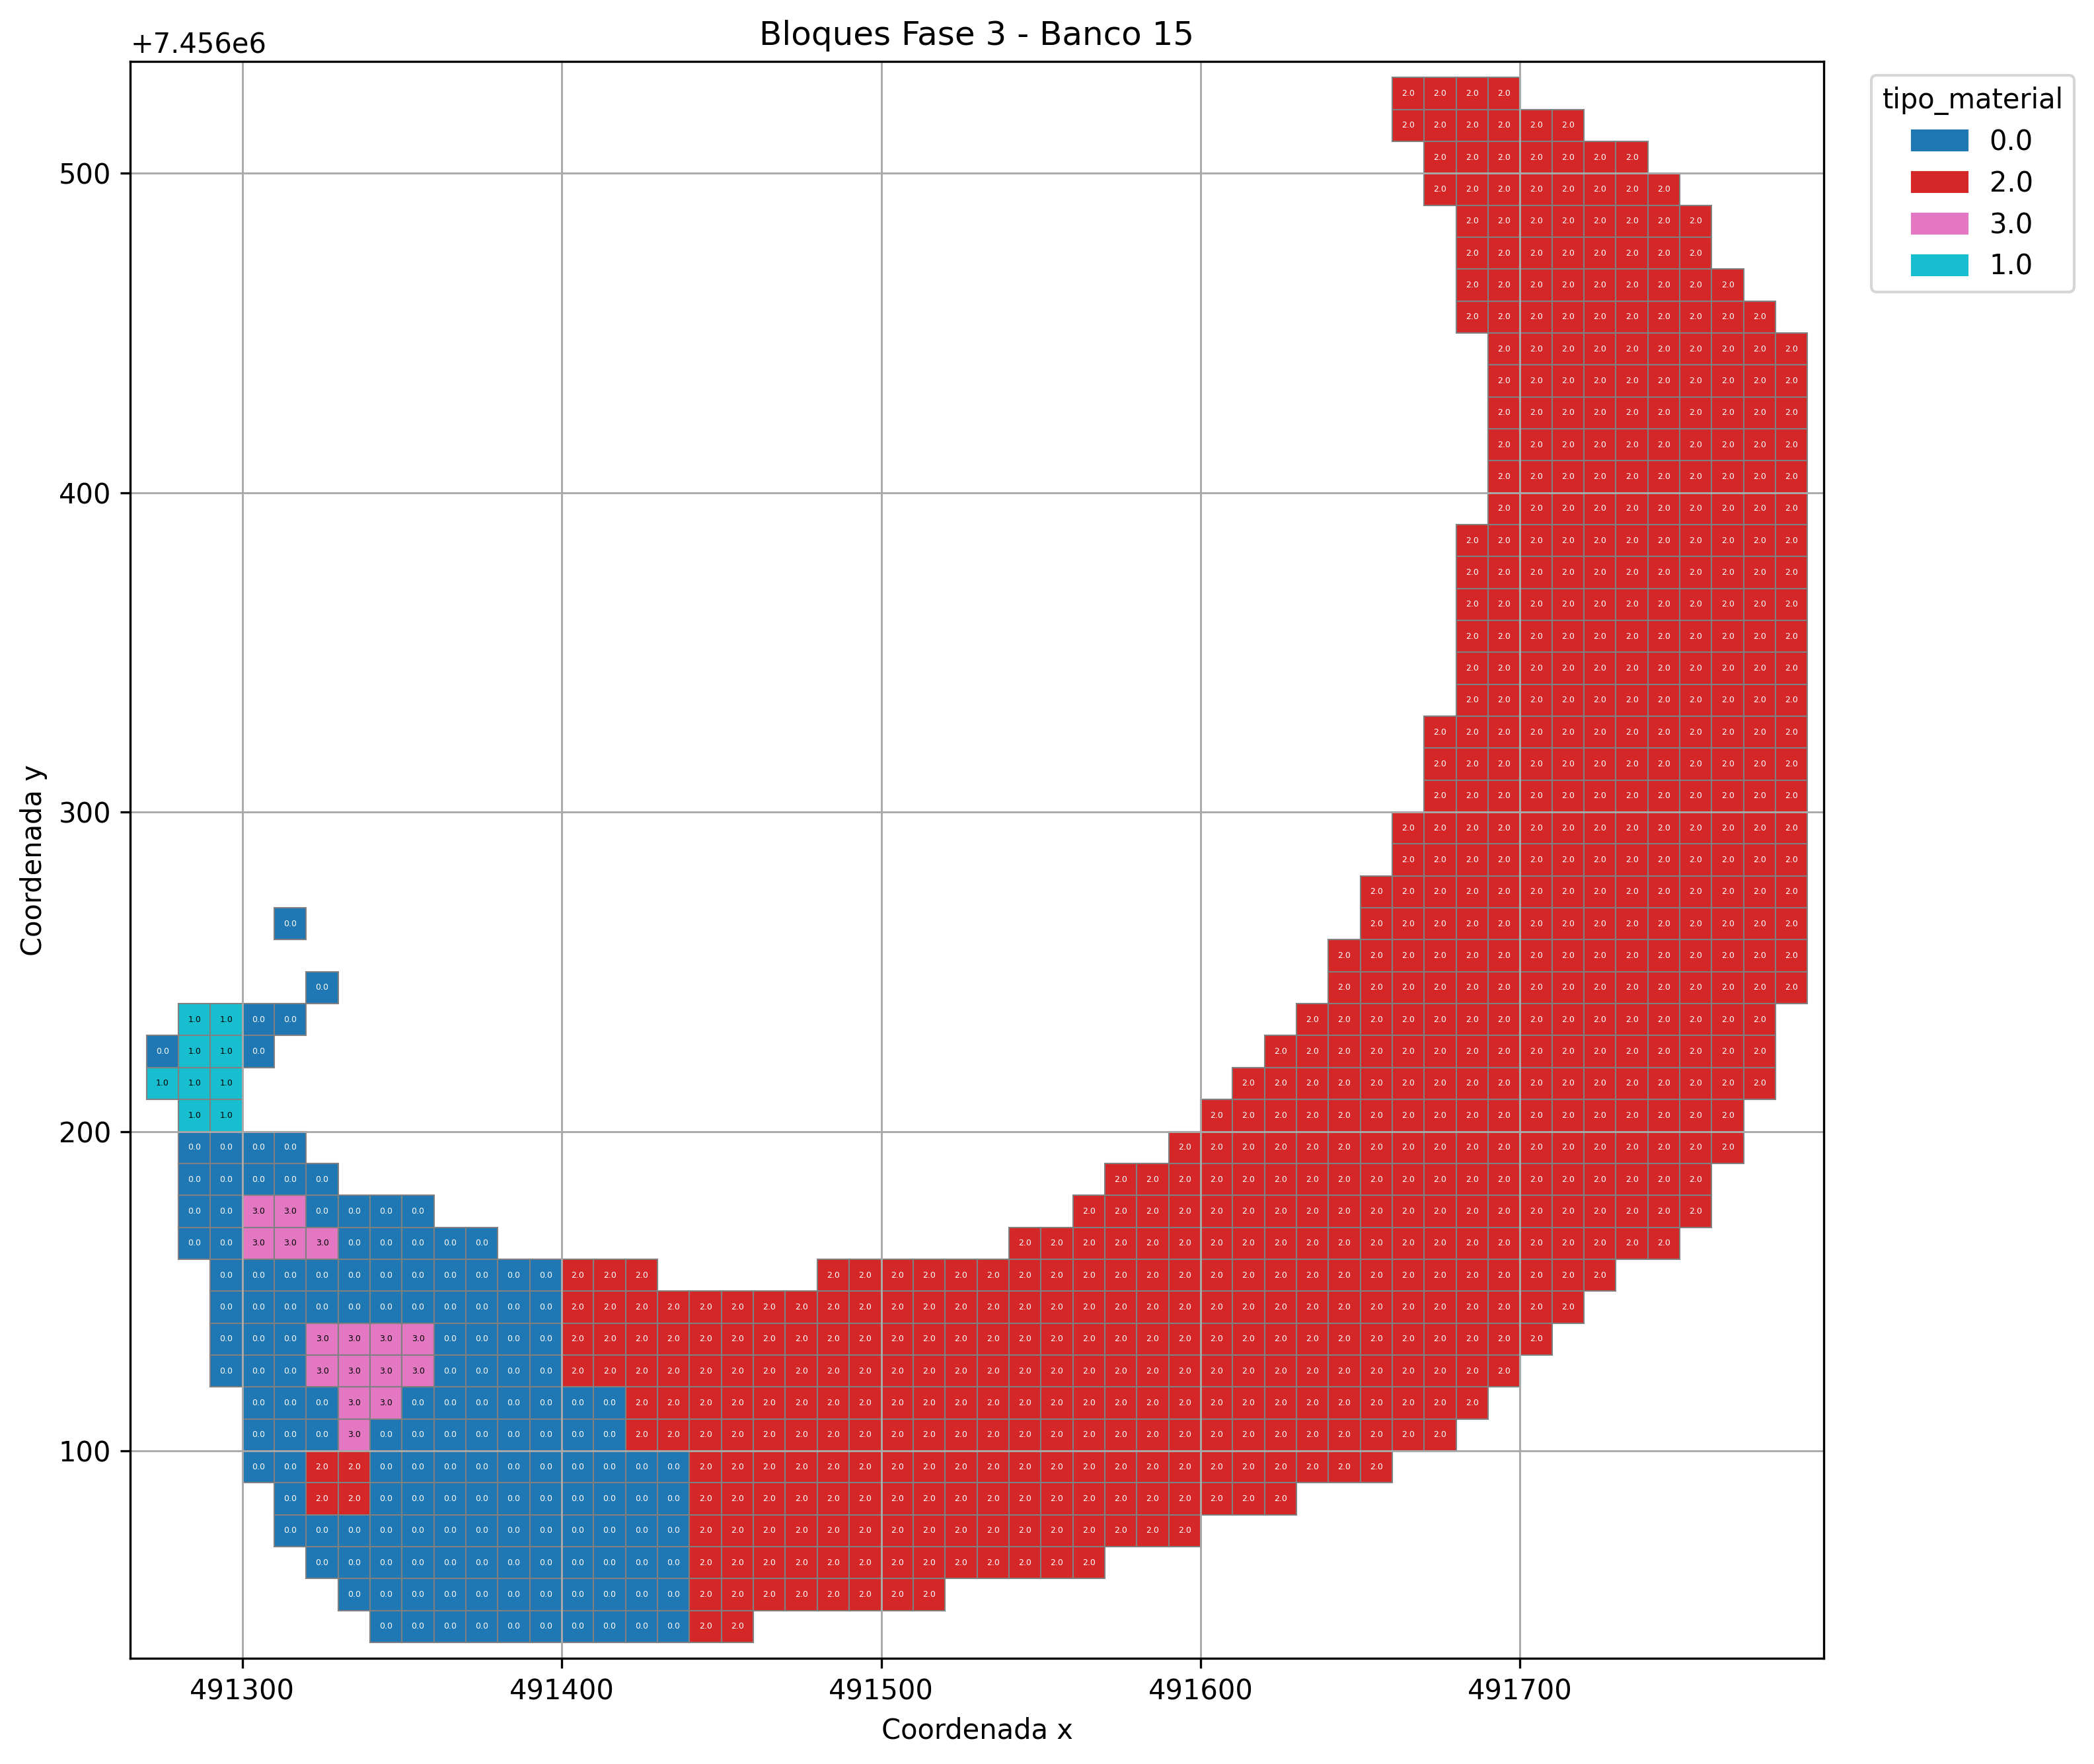

In [3]:
f,b = 3,15
df_filtrado = df_mina[(df_mina['fase']==f)&(df_mina['banco']==b)]
aux.plot_mine_blocks_adv(df_filtrado,
                     color_by_col='tipo_material',
                     title=f"Bloques Fase {f} - Banco {b}",
                     show_block_labels=True, # Mostrar el número de fase
                     fontsize_block_label=3, block_width=10, block_height=10, dpi=300)

### Funciones Aglomeración jerarquica

In [30]:
f,b = 1,6
sub_df = df_mina[(df_mina['fase']==f)&(df_mina['banco']==b)]
len(sub_df)

1859

In [15]:
sub_df

,x,y,z,fase,material,tipo_material,densidad,ley,ID,banco
90982,492055.0,7456265.0,2336.0,3.0,0.0,0.0,2.352,0.015,90983.0,1
91020,492055.0,7456275.0,2336.0,3.0,0.0,0.0,2.352,0.015,91021.0,1
91021,492055.0,7456285.0,2336.0,3.0,0.0,0.0,2.352,0.015,91022.0,1
91022,492055.0,7456295.0,2336.0,3.0,0.0,0.0,2.352,0.015,91023.0,1
91059,492055.0,7456305.0,2336.0,3.0,0.0,0.0,2.352,0.015,91060.0,1


In [31]:
start = time.time()
A,_ = aux.construir_matriz_adyacencia(sub_df) 
S = aux.calcular_matriz_similitud_completa(sub_df)
end = time.time()
print(end-start)                    

12.596014738082886


In [9]:
sub_df

,x,y,z,fase,material,tipo_material,densidad,ley,ID,banco
33051,491295.0,7455995.0,2192.0,3.0,1.0,1.0,2.419096,0.110803,33052.0,10
33052,491305.0,7455995.0,2192.0,3.0,1.0,1.0,2.400482,0.107209,33053.0,10
33060,491315.0,7455985.0,2192.0,3.0,1.0,1.0,2.400482,0.107209,33061.0,10
33061,491325.0,7455985.0,2192.0,3.0,0.0,0.0,2.379709,0.083962,33062.0,10
33062,491335.0,7455985.0,2192.0,3.0,0.0,0.0,2.379709,0.083962,33063.0,10
...,...,...,...,...,...,...,...,...,...,...
46793,491755.0,7456615.0,2192.0,3.0,1.0,1.0,2.515605,0.133264,46794.0,10
46794,491735.0,7456625.0,2192.0,3.0,1.0,1.0,2.587725,0.121669,46795.0,10
46810,491765.0,7456605.0,2192.0,3.0,1.0,1.0,2.425396,0.119392,46811.0,10
46811,491775.0,7456605.0,2192.0,3.0,1.0,1.0,2.425396,0.119392,46812.0,10


In [ ]:
l = aux.hierarchical_mine_clustering_adaptado2(sub_df, A, S, 50, 10)

In [44]:
l2 = aux.hierarchical_mine_clustering_adaptado(sub_df, A, S, 50, 10)

In [41]:
import matplotlib.pyplot as plt

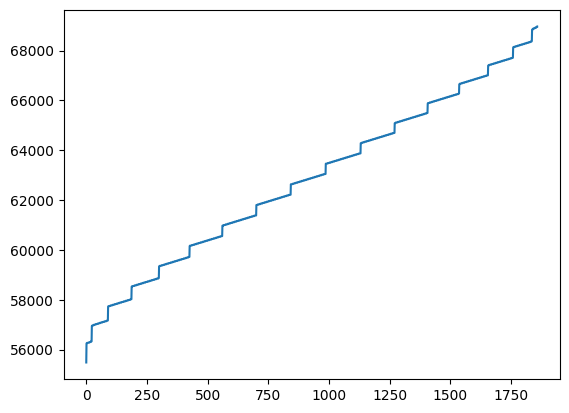

In [42]:
plt.plot(sub_df['ID'].unique())

In [ ]:
df_mina_sim = df_mina.copy()


print("df_mina simulado:")
print(df_mina_sim.head())
print("\nFases y Bancos presentes:")
print(df_mina_sim.groupby(['fase', 'banco']).size())

# 2. Definir parámetros
fases_a_procesar = sorted(df_mina_sim['fase'].unique()) # Procesar todas las fases encontradas
clustering_params = {
    'max_cluster_size': 150,
    'target_num_clusters_per_bench': 4, # Target por banco
    'distancia_adyacencia': 10.0,       # Ajustar a la escala x,y
    'wd': 3,
    'wg': 2,
    'r': 0.5,                          # Factor si material es distinto
    'penalty_factor_c': 0.0001,           # Penalización si clusters de abajo difieren
    'banco_col': 'banco'               # Nombre de la columna de banco
}

# 3. Ejecutar el proceso completo
df_mina_clustered, cluster_details = aux.cluster_mina_por_fase_banco2(
    df_mina=df_mina_sim,
    fases_a_procesar=fases_a_procesar,
    **clustering_params
)

# 4. Verificar resultados en el DataFrame principal
print("\n--- Verificación de Resultados en df_mina ---")
print(df_mina_clustered[['ID', 'fase', 'banco', 'final_cluster_id', 'final_cluster_label']].head(10))
print("\nDistribución de Clusters Finales por Banco:")
print(df_mina_clustered[df_mina_clustered['final_cluster_id'] != -1].groupby(['fase', 'banco', 'final_cluster_label']).size())


df_mina simulado:
          x          y       z  fase  material  tipo_material  densidad  \
0  491425.0  7456205.0  1968.0   4.0       8.0            2.0  2.615598   
1  491435.0  7456195.0  1968.0   4.0       8.0            2.0  2.626056   
2  491445.0  7456195.0  1968.0   4.0       6.0            2.0  2.637350   
3  491455.0  7456195.0  1968.0   4.0       6.0            2.0  2.637350   
4  491435.0  7456205.0  1968.0   4.0       8.0            2.0  2.615598   

        ley   ID  banco  
0  0.550661  1.0     22  
1  0.491924  2.0     22  
2  0.396348  3.0     22  
3  0.396348  4.0     22  
4  0.550661  5.0     22  

Fases y Bancos presentes:
fase  banco
1.0   1         286
      2        2565
      3        2941
      4        2550
      5        2137
               ... 
4.0   19        864
      20        800
      21        768
      22        706
      23        393
Length: 78, dtype: int64

--- Procesando Fase 1.0 ---
  Fase 1.0: Bancos a procesar (descendente): [np.int64(14), np

In [5]:
df_mina_clustered.to_csv("df_mina_clustered_3.csv", index=False)

In [4]:
df_mina_clustered = pd.read_csv("df_mina_clustered_3.csv")

In [7]:
df_mina_clustered['final_cluster_label'].unique()

array(['F4.0_B22_C1', 'F4.0_B22_C2', 'F4.0_B22_C3', ..., 'F3.0_B1_C4',
       'F3.0_B2_C5', 'F3.0_B2_C6'], shape=(1250,), dtype=object)

In [ ]:
# # --- Ejemplo de Uso con Datos Simulados ---
# if __name__ == "__main__":
#     # 1. Crear DataFrame de ejemplo df_mina
#     np.random.seed(42)
#     num_bloques_sim = 50
#     df_mina_sim = pd.DataFrame({
#         'ID': range(num_bloques_sim), # ID original
#         'x': np.random.rand(num_bloques_sim) * 100,
#         'y': np.random.rand(num_bloques_sim) * 100,
#         'z': np.random.randint(1, 3, num_bloques_sim) * 10, # Simular 2 bancos
#         'ley': np.random.uniform(0.1, 2.5, num_bloques_sim),
#         'tipo_material': np.random.choice(['A', 'B', 'C'], num_bloques_sim, p=[0.5, 0.3, 0.2])
#     })
#     print("DataFrame de Mina Simulado (primeras filas):")
#     print(df_mina_sim.head())

#     # 2. Filtrar por un banco (opcional, pero recomendado para probar)
#     df_banco_sim = df_mina_sim[df_mina_sim['z'] == 10].copy()
#     print(f"\nFiltrando por banco Z=10. Número de bloques: {len(df_banco_sim)}")

#     # 3. Definir parámetros de clustering
#     params = {
#         'max_cluster_size': 8,
#         'target_num_clusters': 5,
#         'distancia_adyacencia': 15.0, # Ajustar según escala de coordenadas
#         'wd': 0.1,
#         'wg': 1.0,
#         'r': 0.3 # Factor si material es igual (¡0.3 reduce similitud!)
#     }

#     # 4. Ejecutar clustering
#     if not df_banco_sim.empty:
#         final_clusters = hierarchical_mine_clustering_adaptado(
#             df_input=df_banco_sim,
#             **params
#         )

#         # 5. Mostrar resultados
#         if final_clusters:
#             print("\n--- Clusters Finales ---")
#             for i, cluster in enumerate(final_clusters):
#                 print(f"Cluster {i+1} (Internal ID {cluster['cluster_internal_id']}):")
#                 print(f"  Tamaño: {cluster['size']}")
#                 print(f"  Bloques (IDs Originales): {sorted(list(cluster['blocks']))}")
#     else:
#         print("\nNo hay bloques en el banco seleccionado para el ejemplo.")

In [ ]:
params = {
    'max_cluster_size': 8,
    'target_num_clusters': 5,
    'distancia_adyacencia': 15.0, # Ajustar según escala de coordenadas
    'wd': 0.1,
    'wg': 1.0,
    'r': 0.3 # Factor si material es igual (¡0.3 reduce similitud!)
}

In [6]:
df_copy = df_mina_clustered.copy()

In [ ]:
df_copy['final_cluster_id']

0         1
1         2
2         2
3         2
4         1
         ..
91277     1
91278    23
91279     1
91280    26
91281    26
Name: final_cluster_id, Length: 91282, dtype: int64

El DataFrame está vacío. No se puede generar el gráfico.
Tratando 'final_cluster_id' como Continua.
  Escala de color: min=1.00, max=52.00


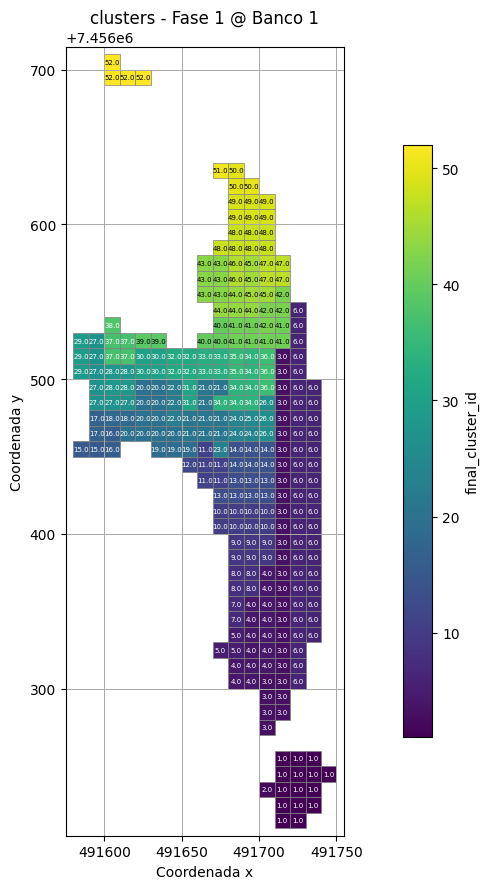

Tratando 'final_cluster_id' como Continua.
  Escala de color: min=1.00, max=629.00


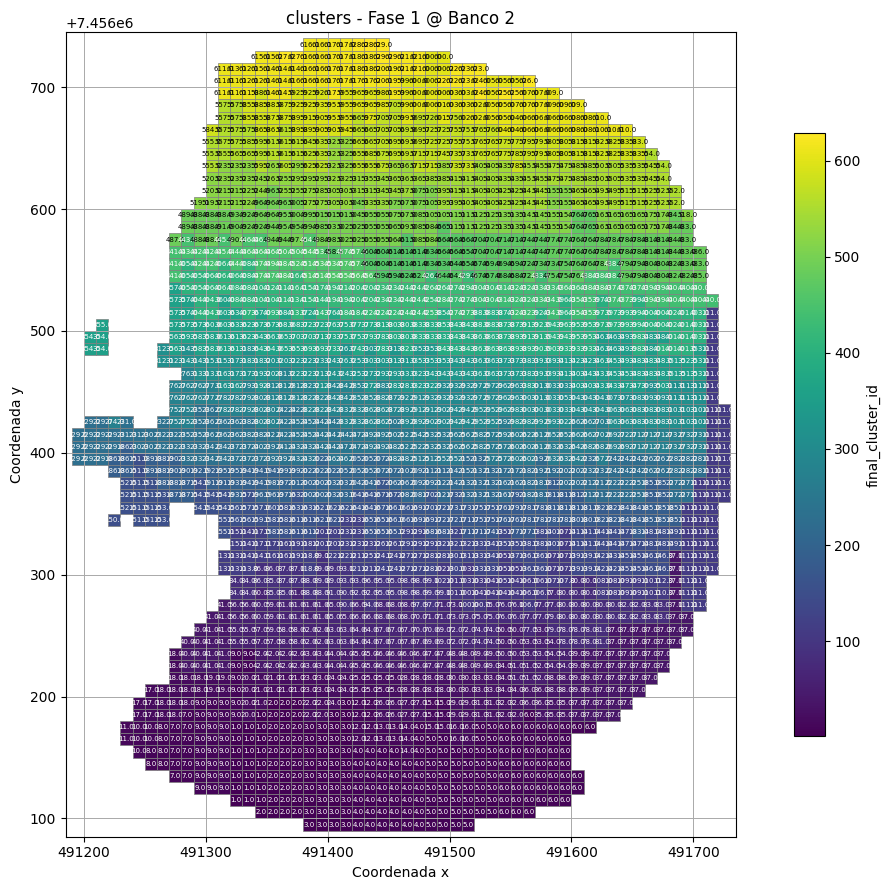

Tratando 'final_cluster_id' como Continua.
  Escala de color: min=1.00, max=675.00


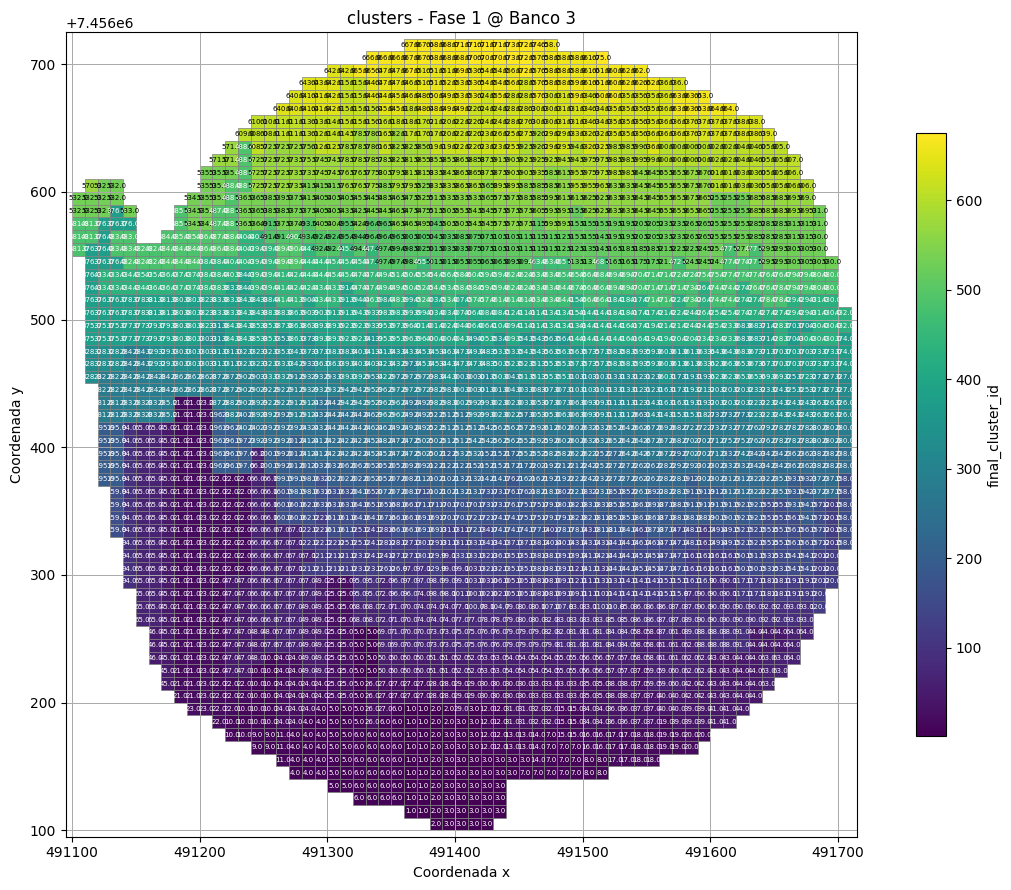

Tratando 'final_cluster_id' como Continua.
  Escala de color: min=1.00, max=607.00


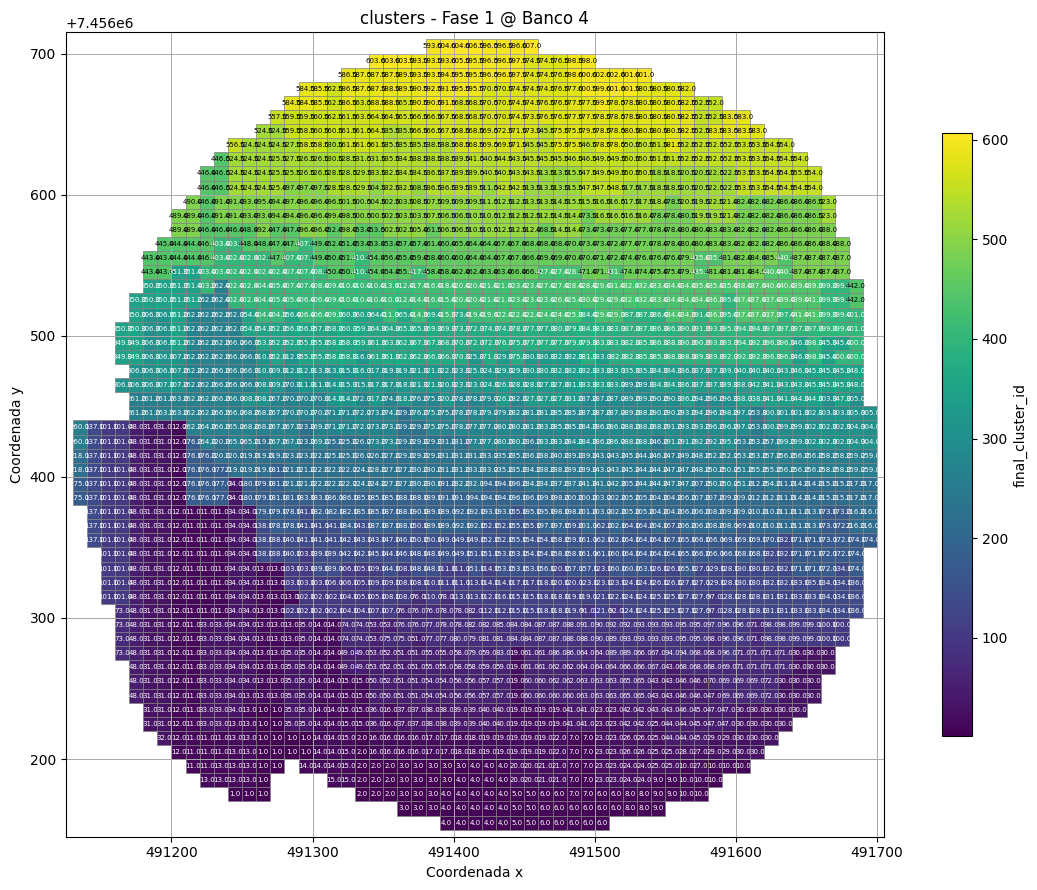

Tratando 'final_cluster_id' como Continua.
  Escala de color: min=1.00, max=537.00


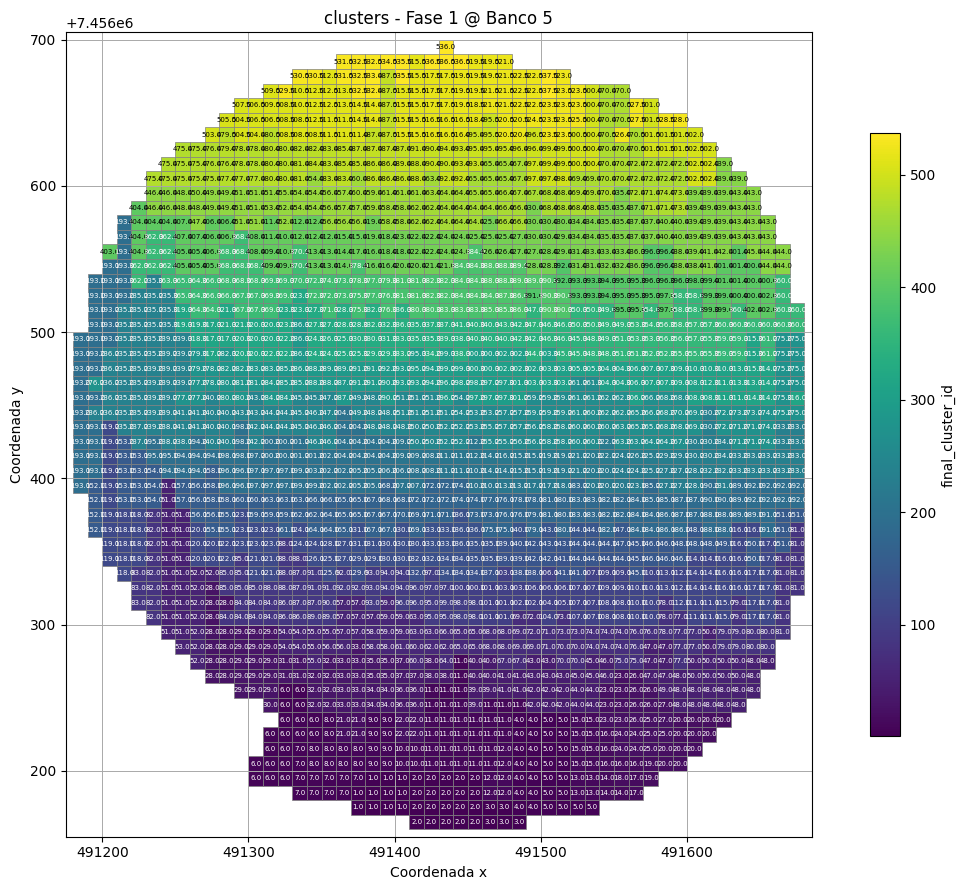

Tratando 'final_cluster_id' como Continua.
  Escala de color: min=1.00, max=499.00


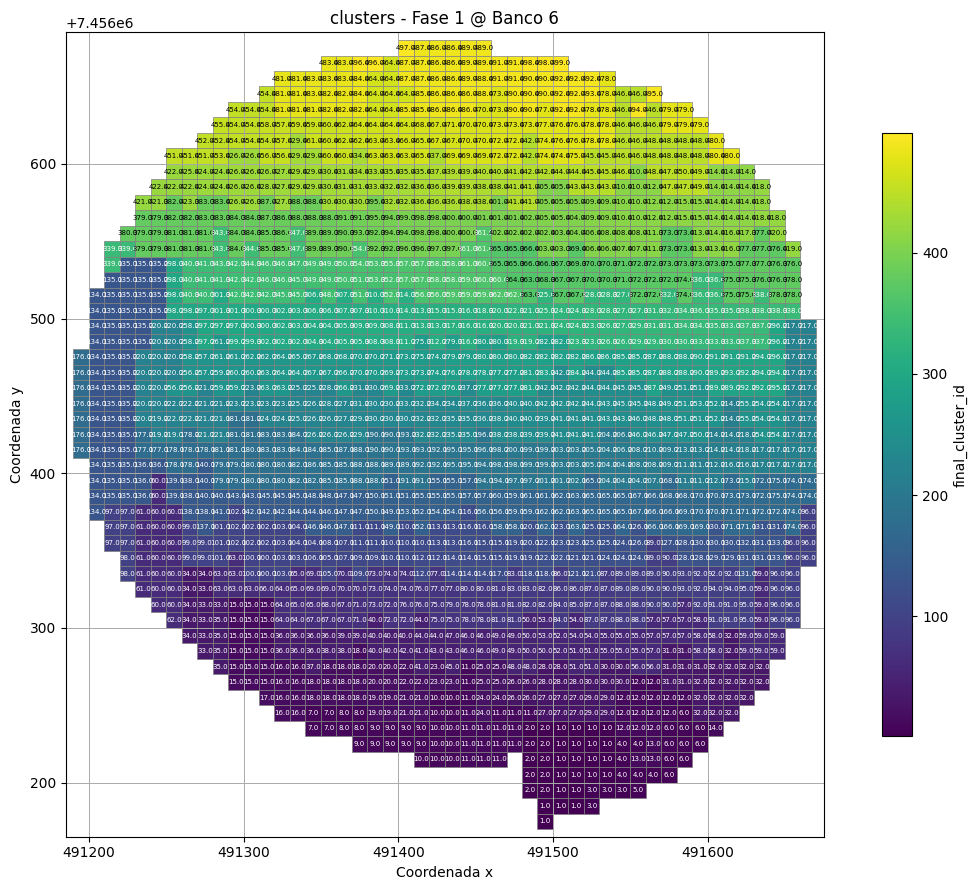

Tratando 'final_cluster_id' como Continua.
  Escala de color: min=1.00, max=446.00


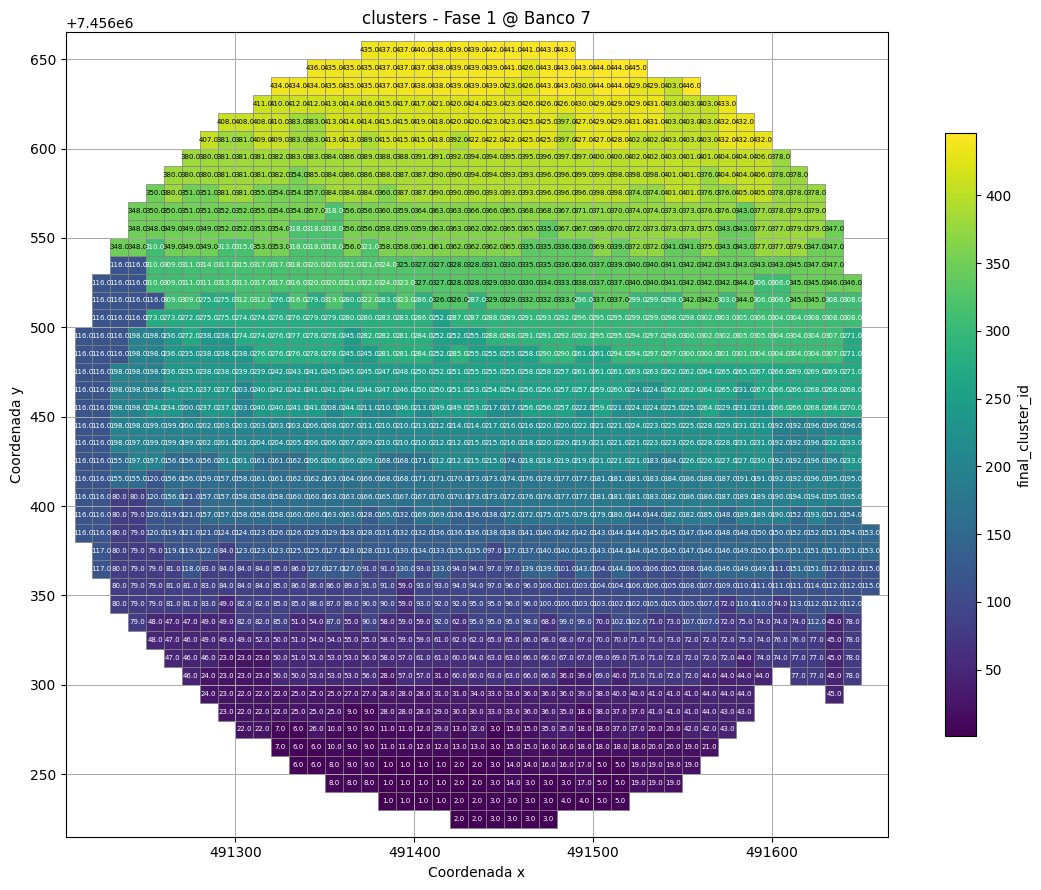

Tratando 'final_cluster_id' como Continua.
  Escala de color: min=1.00, max=390.00


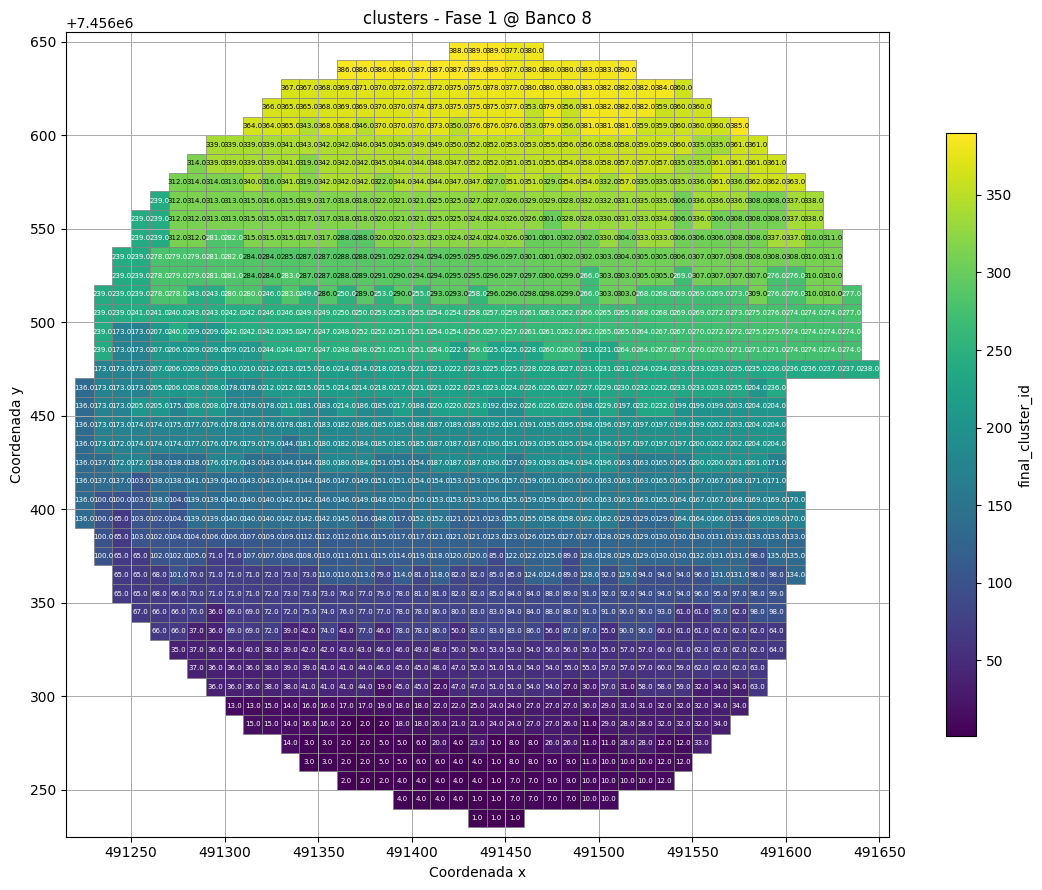

Tratando 'final_cluster_id' como Continua.
  Escala de color: min=1.00, max=324.00


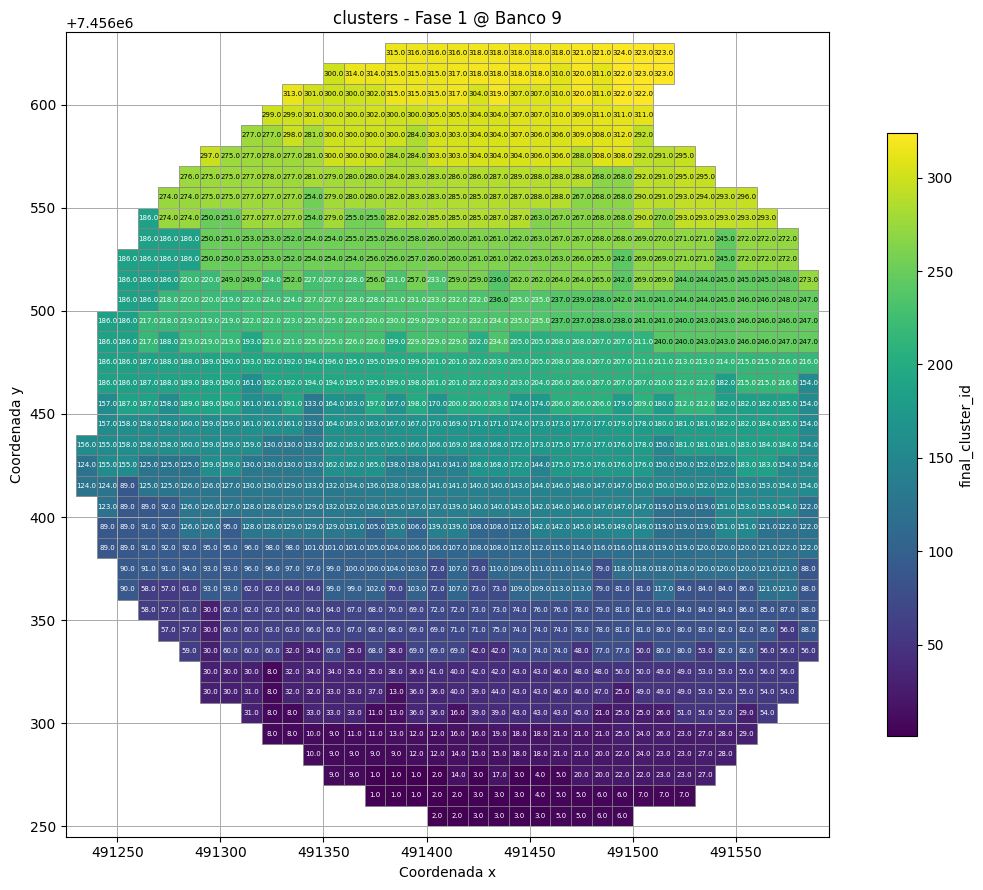

In [8]:
f=1
for b in range(10):
    df_ = df_copy[(df_copy['fase']==f)&(df_copy['banco']==b)]
    aux.plot_mine_blocks_adv(
        df=df_,              # El DataFrame con la nueva columna 'cluster_id'
        color_by_col='final_cluster_id',    # Colorear por el ID del cluster asignado
        block_width=10,               # El tamaño de bloque que usaste
        block_height=10,
        title=f"clusters - Fase {f} @ Banco {b}",
        categorical_threshold=1 + 5, # Asegurar modo categórico
        legend_title="cluster",      # Título para la leyenda
        # cmap='tab10',                 # Un colormap bueno para categorías
        # --- PARÁMETROS CLAVE ---
        show_block_labels=True,       # <--- ¡AÑADE ESTO para activar las etiquetas!
        fontsize_block_label=5        # <--- Establece el tamaño deseado (5 es pequeño, puede funcionar)
        # -----------------------
    )

In [4]:
# Crear columna auxiliar para ordenar por altura (z)
df_mina['altura'] = df_mina['z']

# Agrupar por fase y banco, y ordenar por la altura promedio del grupo (de menor a mayor en z)
grupos_ordenados = sorted(
    df_mina.groupby(['fase', 'banco']),
    key=lambda x: x[1]['z'].mean(),  # usamos la media de z para ordenar
)

# Loop principal
clusters_anterior = None  # Para guardar los clusters del banco inferior

for (fase, banco), df_bloques in grupos_ordenados:
    a = df_bloques['altura'].unique()
    print(f"Procesando fase: {fase}; banco: {banco}; altura: {a}")

Procesando fase: 4.0; banco: 23; altura: [1952.]
Procesando fase: 4.0; banco: 22; altura: [1968.]
Procesando fase: 3.0; banco: 23; altura: [1984.]
Procesando fase: 4.0; banco: 21; altura: [1984.]
Procesando fase: 3.0; banco: 22; altura: [2000.]
Procesando fase: 4.0; banco: 20; altura: [2000.]
Procesando fase: 3.0; banco: 21; altura: [2016.]
Procesando fase: 4.0; banco: 19; altura: [2016.]
Procesando fase: 2.0; banco: 18; altura: [2032.]
Procesando fase: 3.0; banco: 20; altura: [2032.]
Procesando fase: 4.0; banco: 18; altura: [2032.]
Procesando fase: 2.0; banco: 17; altura: [2048.]
Procesando fase: 3.0; banco: 19; altura: [2048.]
Procesando fase: 4.0; banco: 17; altura: [2048.]
Procesando fase: 2.0; banco: 16; altura: [2064.]
Procesando fase: 3.0; banco: 18; altura: [2064.]
Procesando fase: 4.0; banco: 16; altura: [2064.]
Procesando fase: 2.0; banco: 15; altura: [2080.]
Procesando fase: 3.0; banco: 17; altura: [2080.]
Procesando fase: 4.0; banco: 15; altura: [2080.]
Procesando fase: 1.0

In [ ]:
# Loop principal
clusters_anterior = None  # Para guardar los clusters del banco inferior

for (fase, banco), df_bloques in grupos_ordenados:

In [68]:
flag = True
for (fase, banco), df_bloques in df_mina.groupby(['fase', 'banco']):
    print(f'fase: {fase}; banco {banco}')
    # A, df_bloques = construir_matriz_adyacencia(df_bloques)
    # S = calcular_similitud(df_bloques, A)
    # if flag:
    #     break

fase: 1.0; banco 1
fase: 1.0; banco 2
fase: 1.0; banco 3
fase: 1.0; banco 4
fase: 1.0; banco 5
fase: 1.0; banco 6
fase: 1.0; banco 7
fase: 1.0; banco 8
fase: 1.0; banco 9
fase: 1.0; banco 10
fase: 1.0; banco 11
fase: 1.0; banco 12
fase: 1.0; banco 13
fase: 1.0; banco 14
fase: 2.0; banco 1
fase: 2.0; banco 2
fase: 2.0; banco 3
fase: 2.0; banco 4
fase: 2.0; banco 5
fase: 2.0; banco 6
fase: 2.0; banco 7
fase: 2.0; banco 8
fase: 2.0; banco 9
fase: 2.0; banco 10
fase: 2.0; banco 11
fase: 2.0; banco 12
fase: 2.0; banco 13
fase: 2.0; banco 14
fase: 2.0; banco 15
fase: 2.0; banco 16
fase: 2.0; banco 17
fase: 2.0; banco 18
fase: 3.0; banco 1
fase: 3.0; banco 2
fase: 3.0; banco 3
fase: 3.0; banco 4
fase: 3.0; banco 5
fase: 3.0; banco 6
fase: 3.0; banco 7
fase: 3.0; banco 8
fase: 3.0; banco 9
fase: 3.0; banco 10
fase: 3.0; banco 11
fase: 3.0; banco 12
fase: 3.0; banco 13
fase: 3.0; banco 14
fase: 3.0; banco 15
fase: 3.0; banco 16
fase: 3.0; banco 17
fase: 3.0; banco 18
fase: 3.0; banco 19
fase: 3

In [67]:
df_bloques

,x,y,z,fase,material,tipo_material,densidad,ley,ID,banco
0,491715.0,7456215.0,2304.0,1.0,0.0,0.0,2.293829,0.012293,78991.0,1
1,491725.0,7456215.0,2304.0,1.0,0.0,0.0,2.263131,0.012950,78992.0,1
2,491715.0,7456225.0,2304.0,1.0,0.0,0.0,2.303219,0.011180,78993.0,1
3,491725.0,7456225.0,2304.0,1.0,0.0,0.0,2.256253,0.011809,78994.0,1
4,491705.0,7456235.0,2304.0,1.0,0.0,0.0,2.303219,0.011180,78995.0,1
...,...,...,...,...,...,...,...,...,...,...
281,491685.0,7456635.0,2304.0,1.0,0.0,0.0,2.303350,0.083556,87389.0,1
282,491605.0,7456695.0,2304.0,1.0,0.0,0.0,2.390991,0.015000,88275.0,1
283,491605.0,7456705.0,2304.0,1.0,0.0,0.0,2.401936,0.015000,88276.0,1
284,491615.0,7456695.0,2304.0,1.0,0.0,0.0,2.390991,0.015000,88295.0,1


In [66]:
S

{(np.int64(0), np.int64(1)): np.float64(26.066042999999997),
 (np.int64(0), np.int64(2)): np.float64(26.066042999999997),
 (np.int64(1), np.int64(3)): np.float64(26.066042999999997),
 (np.int64(2), np.int64(3)): np.float64(26.066042999999997),
 (np.int64(2), np.int64(5)): np.float64(26.066042999999997),
 (np.int64(3), np.int64(6)): np.float64(26.066042999999997),
 (np.int64(3), np.int64(7)): np.float64(26.066042999999997),
 (np.int64(4), np.int64(5)): np.float64(26.066042999999997),
 (np.int64(5), np.int64(6)): np.float64(26.066042999999997),
 (np.int64(5), np.int64(9)): np.float64(26.066042999999997),
 (np.int64(6), np.int64(8)): np.float64(26.066042999999997),
 (np.int64(6), np.int64(10)): np.float64(26.066042999999997),
 (np.int64(7), np.int64(8)): np.float64(26.066042999999997),
 (np.int64(8), np.int64(13)): np.float64(26.066042999999997),
 (np.int64(9), np.int64(10)): np.float64(26.066042999999997),
 (np.int64(9), np.int64(11)): np.float64(26.066042999999997),
 (np.int64(10), np.i

In [55]:
df_bloques

,x,y,z,fase,material,tipo_material,densidad,ley,banco
78990,491715.0,7456215.0,2304.0,1.0,0.0,0.0,2.293829,0.012293,1
78991,491725.0,7456215.0,2304.0,1.0,0.0,0.0,2.263131,0.012950,1
78992,491715.0,7456225.0,2304.0,1.0,0.0,0.0,2.303219,0.011180,1
78993,491725.0,7456225.0,2304.0,1.0,0.0,0.0,2.256253,0.011809,1
78994,491705.0,7456235.0,2304.0,1.0,0.0,0.0,2.303219,0.011180,1
...,...,...,...,...,...,...,...,...,...
87388,491685.0,7456635.0,2304.0,1.0,0.0,0.0,2.303350,0.083556,1
88274,491605.0,7456695.0,2304.0,1.0,0.0,0.0,2.390991,0.015000,1
88275,491605.0,7456705.0,2304.0,1.0,0.0,0.0,2.401936,0.015000,1
88294,491615.0,7456695.0,2304.0,1.0,0.0,0.0,2.390991,0.015000,1


In [27]:
np.transpose(np.nonzero(np.triu(A, k=1)))

array([[  0,   2],
       [  1,   2],
       [  1,   4],
       ...,
       [388, 389],
       [390, 391],
       [391, 392]], shape=(731, 2))

In [29]:
np.max([5,6.53])

np.float64(6.53)

In [72]:
f,b = 2,1
df_mina[(df_mina['fase']==f)&(df_mina['banco']==b)]['z']

73888    2304.0
73889    2304.0
73890    2304.0
73891    2304.0
73892    2304.0
          ...  
88793    2304.0
88794    2304.0
88795    2304.0
88818    2304.0
88819    2304.0
Name: z, Length: 973, dtype: float64

In [77]:
f,b = 1,2
df_filtrado = df_mina[(df_mina['fase']==f)&(df_mina['banco']==b)]
df_filtrado['altura'].unique()

array([2288.])

Tratando 'tipo_material' como Categórica (3 valores únicos).


/tmp/ipykernel_2051/582117119.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_unique)


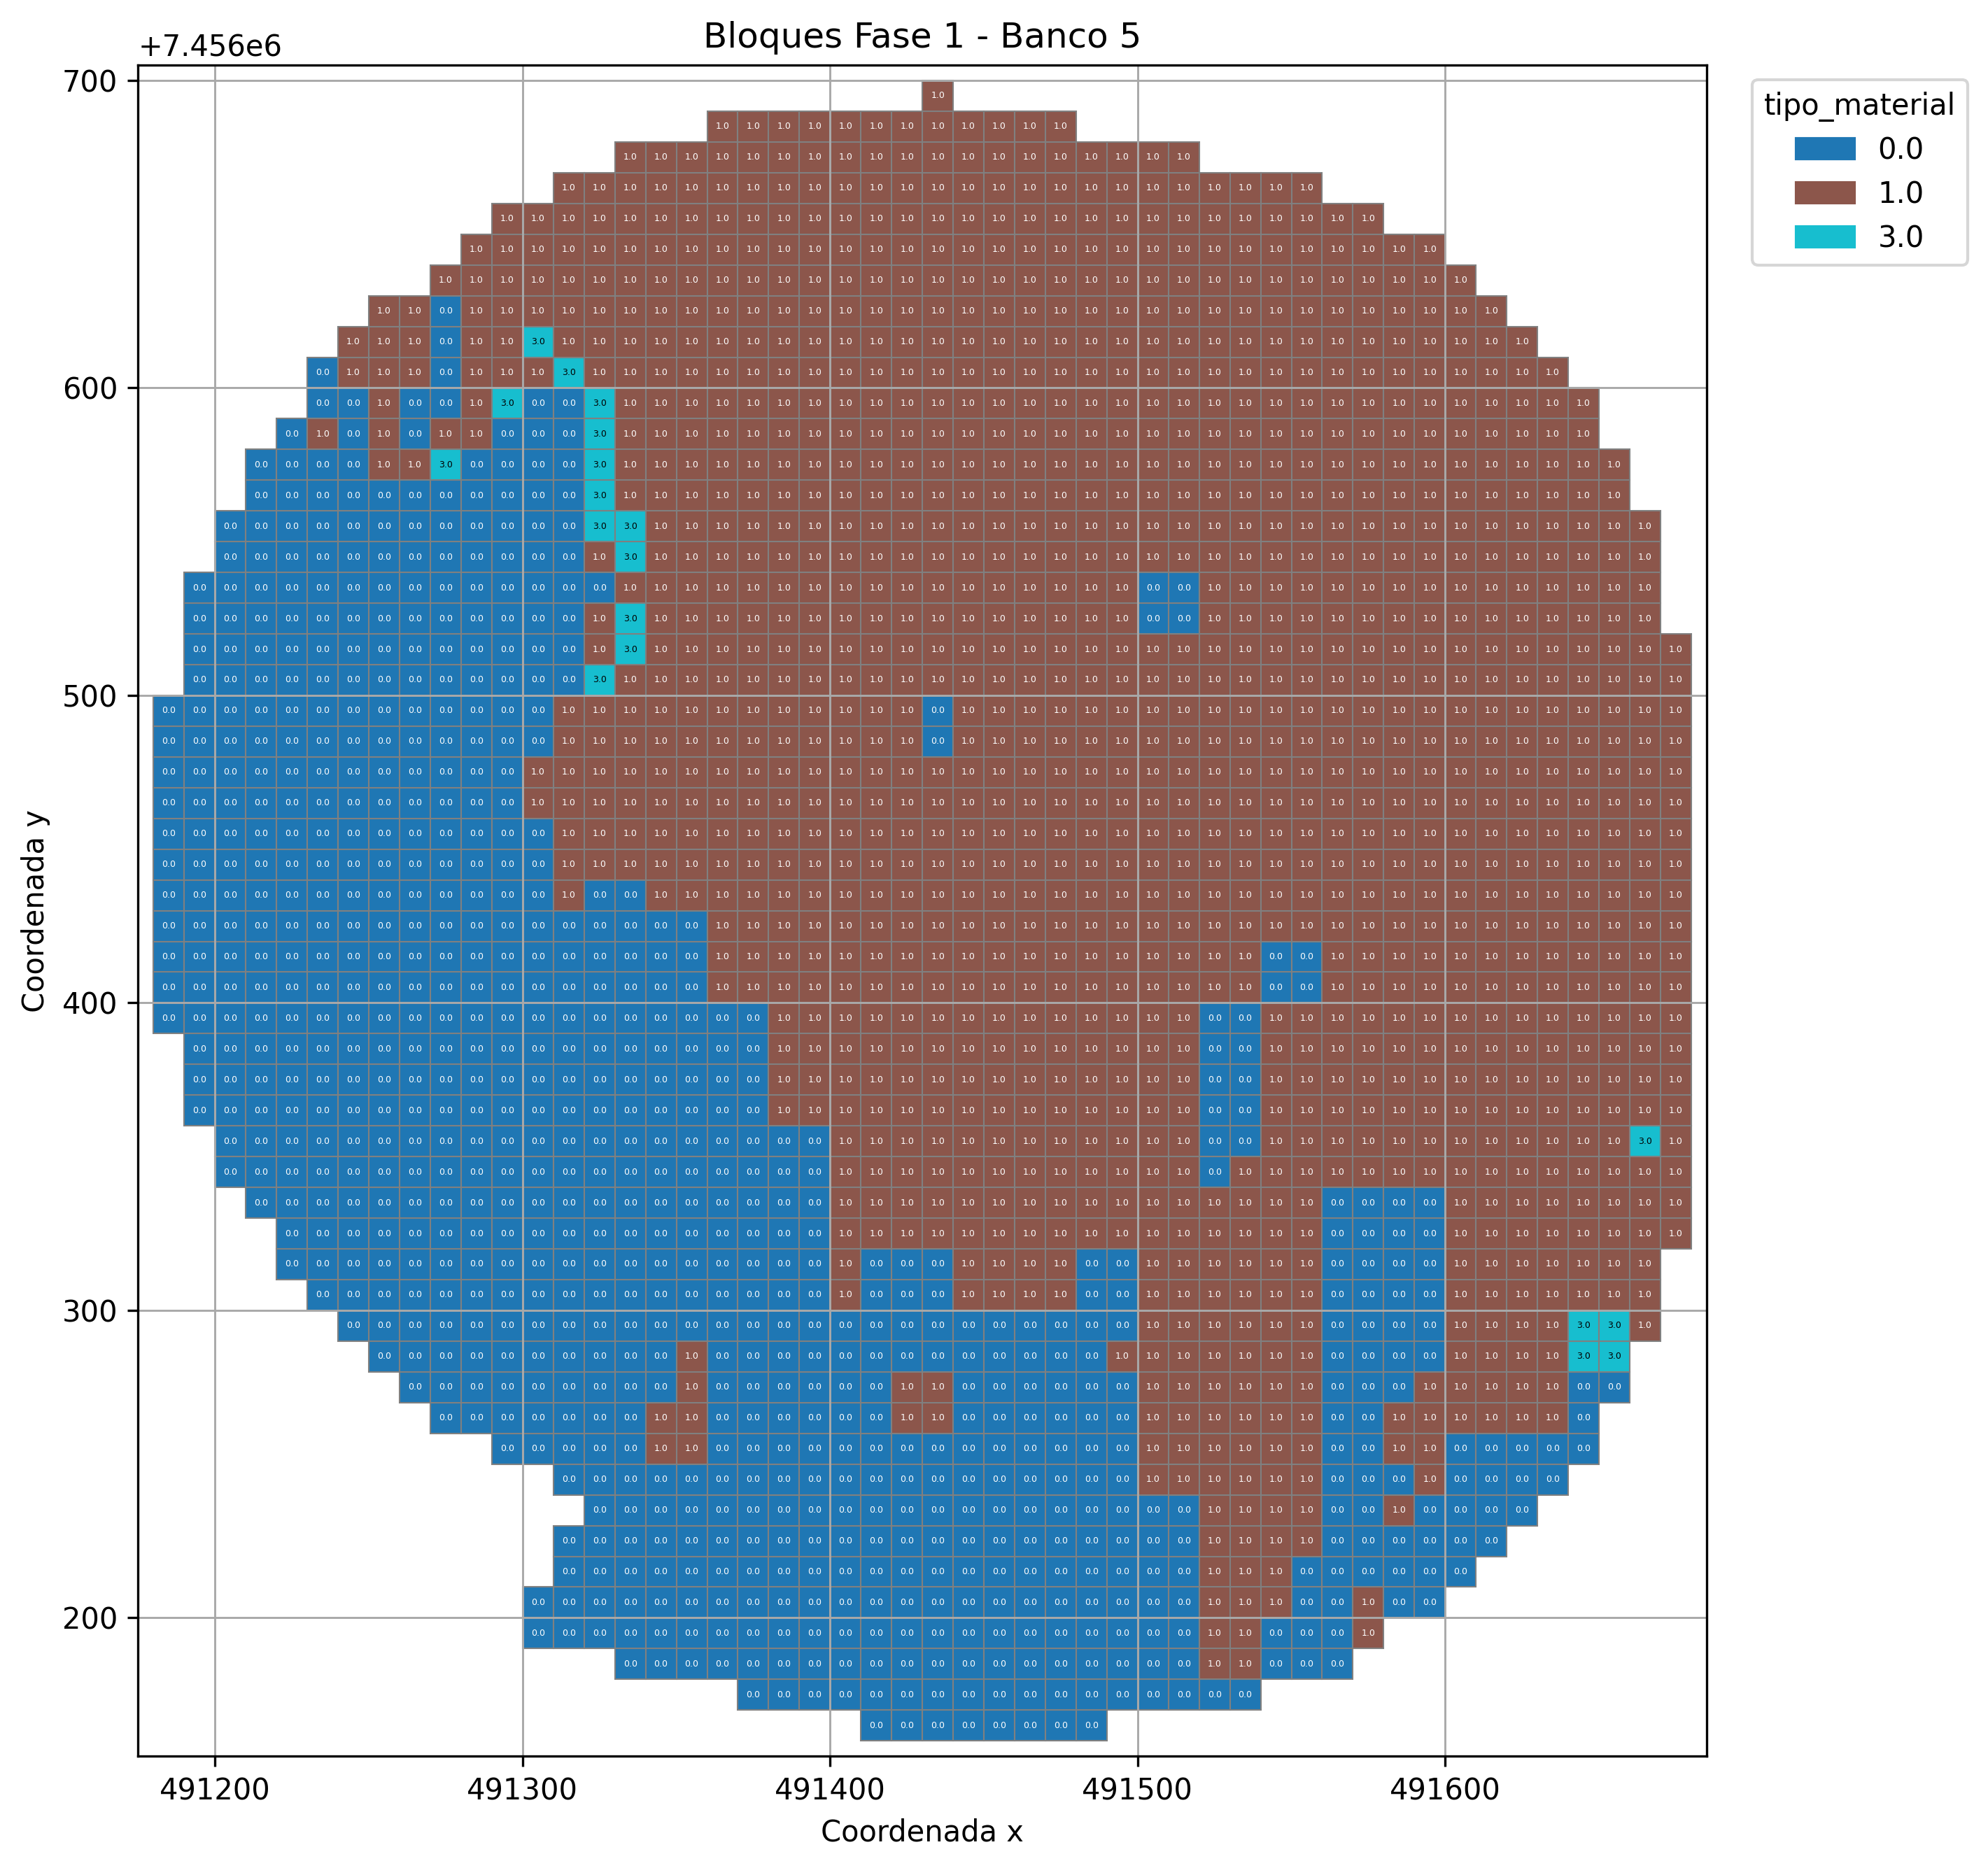

In [ ]:
mapa_color_fases = {
    5: '#1f77b4', # Azul
    6: '#ff7f0e', # Naranja
    7: '#2ca02c', # Verde
    8: '#d62728', # Rojo
    9: '#9467bd'  # Morado
}


In [3]:
P = 4
R = 0.85 
C_r = 0.25 
C_m = 2 
C_p = 10 
FTL = 2204.62 # Factor tonelada-libra

In [4]:
coord_z = mina[:,2] 
coord_z = [float(h) for h in coord_z] # Pasar a lista
alturas = np.unique(coord_z)
alturas = [int(b) for b in alturas] #pasar a lista
cut = mina[:,7] 
cut = [float(b)/100 for b in cut]
densidad = mina[:,8]
fase = mina[:,15]
fases = np.unique(fase)
fases = [int(f) for f in fases] # Pasar a lista
enumeracion = mina[:,16] 
ley_marginal = C_p/((P-C_r)*FTL*R)
ley_critica = (C_p + C_m)/((P-C_r)*FTL*R)
ley_maxima = 0.004216
P_min = 2 
P_max = 4 
H_diff = 16  
volumen_bloque = 1600 
altura = [[] for _ in range(len(fases))] 
alt = [[] for _ in range(len(fases))]
T = range(1,35)
r = 0.1

In [5]:
#fase es un array con el valor de la fase correspondiente al bloque
# fases es una lista 1,2,3,..,n_fases
# enumeracion es un array que basicamente es el indice de los bloques
for ID in enumeracion: # for ID en bloques
    for f in range(len(fases)): # for f fase valida
        if fase[int(ID)-1] == fases[f]: # si el bloque tiene la misma fase, agregamos la coordenada z a la lista alt[f] (alturas fase f)
            alt[f].append(coord_z[int(ID)-1])

In [6]:
for f in range(len(fases)): # for f fase valida
    altura[f] = np.unique(alt[f]) # la lista altura[f] tiene los elementos unicos de alt[f]

In [7]:
P_fb = [[[] for _ in range(len(alturas))] for _ in range(len(fases))]
# Es una lista de listas[f], f fase valids, listas[f] es una lista de |cantidad de alturas distintas en la fase f| listas vacias

In [8]:
for f in range(len(fases)): # f in fases
    for b in range(len(altura[f])): # b in banco?, va de 0 a alturas-1
        # Inicializacion de flags Arriba Lado Abajo
        Condicion_Arriba = True
        Condicion_Lado = True
        Condicion_Abajo = True
        # Check arriba
        if Condicion_Arriba:
            if b+1 < len(altura[f]):
                P_fb[f][b].append([f,b+1]) 
                Condicion_Arriba = False
            for fn in range(len(fases)): 
                for bn in range(len(altura[fn])): 
                    if(fn-f) == 1: 
                        if(altura[fn][bn] - altura[f][b]) == P_max*H_diff: 
                            if Condicion_Lado:
                                P_fb[f][b].append([fn,bn]) 
                                Condicion_Lado = False
        for fn in range(len(fases)):
            for bn in range(len(altura[fn])):
                if(f-fn) == 1: 
                    if(altura[f][b] - altura[fn][bn]) == P_min*H_diff:
                        if Condicion_Abajo:
                            P_fb[f][b].append([fn,bn])
                            Condicion_Abajo = False

In [19]:
## Nuevo code
data_fb = [[{} for _ in range(len(altura[f]))] for _ in range(len(fases)) ]
cortes_fb = [[[] for _ in range(len(altura[f]))] for _ in range(len(fases))]
for ID in enumeracion: 
    for f in range(len(fases)): 
        if  f+1 == int(fase[int(ID)-1]): # if fase_bloque = fase f
            for b in range(len(altura[f])): # for b in banco(f) 
                if altura[f][b] == coord_z[int(ID)-1]: # if altura_bloque = altura_f_b
                    cortes_fb[f][b].append(cut[int(ID)-1])
                    data_fb[f][b][int(ID)-1] = (cut[int(ID)-1],float(densidad[int(ID)-1])*volumen_bloque,float(densidad[int(ID)-1])*volumen_bloque*float(cut[int(ID-1)])) # Corte, peso_mineral, peso_fino

for f in range(len(fases)):
    for b in range(len(altura[f])): # For (f,b) 
        cortes_fb[f][b] = list(set(cortes_fb[f][b]))
        cortes_fb[f][b] = list(np.quantile(cortes_fb[f][b], [0.25, 0.5, 0.75]))
        cortes_fb[f][b].append(1)

In [23]:
peso_mineral       = [[[[] for _ in range(len(cortes_fb[f][b]))] for b in range(len(altura[f]))] for f in range(len(fases))] 
# peso_mineral[alturas unicas][fases unicas][leyes_unicas] [ lista vacia]
peso_fino          = [[[[] for _ in range(len(cortes_fb[f][b]))] for b in range(len(altura[f]))] for f in range(len(fases))] 

# peso_fino[alturas unicas][fases unicas][leyes_unicas] [lista vacia]




for ID in enumeracion: 
    for f in range(len(fases)): 
        if  f+1 == int(fase[int(ID)-1]): # if fase_bloque = fase f
            for b in range(len(altura[f])): # for b in banco(f) 
                if altura[f][b] == coord_z[int(ID)-1]: # if altura_bloque = altura_f_b   
                     for k in range(len(cortes_fb[f][b])):  # for k in len(leyes_f_b)
                        if cut[int(ID)-1] >= cortes_fb[f][b][k]: # Sí la ley del bloque es mayor a la ley_k
                            peso_mineral[f][b][k].append(float(densidad[int(ID)-1])*volumen_bloque) # Agregar el peso a la lista
                            peso_fino[f][b][k].append(float(densidad[int(ID)-1])*volumen_bloque*float(cut[int(ID-1)]))  # Agregar su peso fino correspondiente

sum_peso_mineral = [[[0 for _ in range(len(cortes_fb[f][b]))] for b in range(len(altura[f]))] for f in range(len(fases))] 
sum_peso_fino = [[[0 for _ in range(len(cortes_fb[f][b]))] for b in range(len(altura[f]))] for f in range(len(fases))] 
for f in range(len(fases)): 
    for b in range(len(altura[f])): # For (f,b)  
        for k in range(len(cortes_fb[f][b])): # for k en leyes fb
            # Se calcula la suma correspondiente
            sum_peso_mineral[f][b][k] = sum(peso_mineral[f][b][k]) #Suma de pesos
            sum_peso_fino[f][b][k] = sum(peso_fino[f][b][k]) #Peso fino


In [25]:
M = {}
ep = {}
mu = {}
h = {}

for f in range(len(fases)): 
    for b in range(len(altura[f])): # For (f,b)  
        for k in range(len(cortes_fb[f][b])): # for k en leyes fb
            if sum_peso_mineral[f][b][k] != 0: 
                M[f,b,k] = sum_peso_mineral[f][b][k] # Masa con ley corte k
                h[f,b,k] = sum_peso_fino[f][b][k]/sum_peso_mineral[f][b][k] # Ley media

for f in range(len(fases)):
    for b in range(len(altura[f])): # For (f,b)  
        for k in range(len(cortes_fb[f][b])): # for k en leyes fb
            if (f, b, k) in M: 
                if cortes_fb[f][b][k] >  0:
                    ep[f,b,k] = (M[f,b,0]-M[f,b,k])/M[f,b,0] # Complemento
                    mu[f,b,k] = M[f,b,k]/M[f,b,0] #Concentracion
                elif cortes_fb[f][b][k] == 0:
                    ep[f,b,k] = 1
                    mu[f,b,k] = 0  
capacidad_maxima_planta = 5500000
capacidad_maxima_mina = 16000000

In [26]:
I = {}
for f in range(len(fases)):
    for b in range(len(altura[f])): # For (f,b)  
        for k in range(len(cortes_fb[f][b])): # for k en leyes fb
            if (f, b, k) in M: 
                # (1/(1+r)**t)*((P-C_r)*R*FTL*h[f,b,k]*mu[f,b,k]*x[f,b,t,k]-(C_m+C_p)*mu[f,b,k]*x[f,b,t,k]-C_m*ep[f,b,k]*x[f,b,t,k])
                I[f,b,k] = (P-C_r)*R*FTL*h[f,b,k]*mu[f,b,k]-(C_m+C_p)*mu[f,b,k]-C_m*ep[f,b,k]

$\sum_{t=1}^N \frac{1}{(1+r)^t} \left(\sum_{f,b,k} I_{f,b,k} \hat{y}_{f,b,t,k}\right) x_{f,b,t}$

In [27]:
for f in range(len(fases)):
    for b in range(len(altura[f])):
        leyes_eliminar = {}
        valores = {}
        for k in range(len(cortes_fb[f][b])):
            if (f,b,k) in M:
                valor = M[f,b,k]
                if valor in valores:
                    leyes_eliminar[f,b,k] = cortes_fb[f][b][k]
                else:
                    valores[valor] = k
            else:
                leyes_eliminar[f,b,k] = cortes_fb[f][b][k]

In [44]:
fbk_indexes = []
fbtk_indexes = []
for f in range(len(fases)):
    for b in range(len(altura[f])):
        for t in T:
            for k in range(len(cortes_fb[f][b])):
                fbtk_indexes.append((f,b,t,k))
fbt_indexes = []
for f in range(len(fases)):
    for b in range(len(altura[f])):
        for t in T:
            fbt_indexes.append((f,b,t))

In [45]:
MP = Model()
eta = MP.addVar(name='eta', vtype = GRB.CONTINUOUS)
y = MP.addVars(fbtk_indexes, vtype= GRB.BINARY, name='y')
z = MP.addVars(fbt_indexes, vtype = GRB.BINARY, name='z')
# Agregar restricciones



In [50]:
for f in range(len(fases)):
    for b in range(len(altura[f])):
        for t in T:
            MP.addConstr(quicksum(y[f,b,t,k] for k in range(len(cortes_fb[f][b]))) <= 1)#3
            if t != 1:
                MP.addConstr(z[f,b,t-1] <= z[f,b,t])#9
            if len(P_fb[f][b]) != 0:
                MP.addConstr(quicksum(z[fn, bn, t] for fn, bn in P_fb[f][b]) / len(P_fb[f][b]) >= quicksum(y[f, b, t, k] for k in range(len(cortes_fb[f][b]))))#8

In [51]:
y[0,0,1,0]

<gurobi.Var *Awaiting Model Update*>

In [35]:
MP.setObjective(eta, sense=GRB.MAXIMIZE)

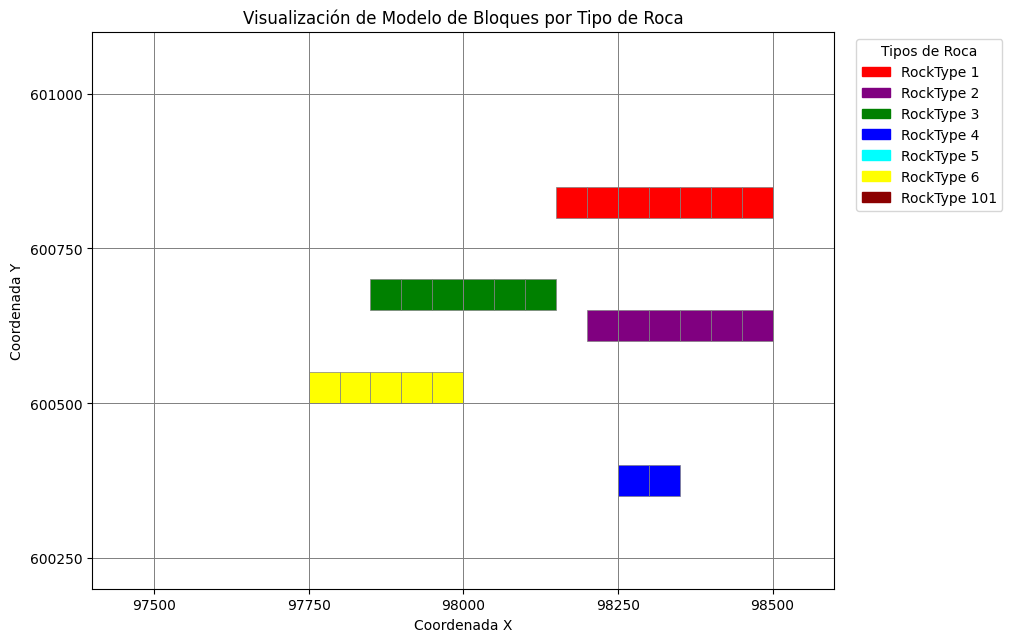

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# --- 1. Preparación de Datos (Ejemplo) ---
# En un caso real, cargarías tus datos desde un archivo (CSV, Excel, etc.)
# df = pd.read_csv('tus_datos_de_bloques.csv')

# Creando un DataFrame de ejemplo que se asemeje a la estructura visualizada
# Necesitamos coordenadas (X, Y) del CENTRO de cada bloque y el tipo de roca.
# Asumiremos un tamaño de bloque, por ejemplo, 50x50 unidades, basado en la cuadrícula visual.
block_width = 50
block_height = 50

data = {
    'X_Center': [97775, 97825, 97875, 97925, 97975, # Fila 1 (amarillo ~6)
                 97875, 97925, 97975, 98025, 98075, 98125, # Fila 2 (verde ~3)
                 98175, 98225, 98275, 98325, 98375, 98425, 98475, # Fila 3 (rojo ~1)
                 98225, 98275, 98325, 98375, 98425, 98475, # Fila 4 (morado ~2)
                 98275, 98325], # Fila 5 (azul ~4)
    'Y_Center': [600525, 600525, 600525, 600525, 600525, # Fila 1
                 600675, 600675, 600675, 600675, 600675, 600675, # Fila 2
                 600825, 600825, 600825, 600825, 600825, 600825, 600825, # Fila 3
                 600625, 600625, 600625, 600625, 600625, 600625, # Fila 4
                 600375, 600375], # Fila 5
    'RockType': [6, 6, 6, 6, 6,  # Fila 1
                 3, 3, 3, 3, 3, 3, # Fila 2
                 1, 1, 1, 1, 1, 1, 1, # Fila 3
                 2, 2, 2, 2, 2, 2, # Fila 4
                 4, 4] # Fila 5
}
df = pd.DataFrame(data)

# --- 2. Definición de Colores para Tipos de Roca ---
# Mapea los códigos de RockType a colores. Puedes extender esto según tu leyenda.
# Los colores son aproximados a los de la imagen.
color_map = {
    1: 'red',        # Tipo 1 (Rojo)
    2: 'purple',     # Tipo 2 (Morado)
    3: 'green',      # Tipo 3 (Verde)
    4: 'blue',       # Tipo 4 (Azul)
    5: 'cyan',       # Tipo 5 (Cian - No en ejemplo, pero en leyenda)
    6: 'yellow',     # Tipo 6 (Amarillo)
    # Agrega más tipos de roca y sus colores si es necesario
    101: 'darkred',
    102: 'darkmagenta',
    103: 'darkgreen',
    201: 'darkblue',
    # ... y así sucesivamente según la leyenda completa
}

# Crear un diccionario para la leyenda (invertido: color -> nombre/código)
# Podrías tener nombres más descriptivos si los tienes.
legend_labels = {
    'red': 'RockType 1',
    'purple': 'RockType 2',
    'green': 'RockType 3',
    'blue': 'RockType 4',
    'cyan': 'RockType 5',
    'yellow': 'RockType 6',
    'darkred': 'RockType 101',
    # ... etc.
}

# --- 3. Creación del Gráfico ---
fig, ax = plt.subplots(figsize=(12, 9)) # Ajusta el tamaño si es necesario

# Iterar sobre cada bloque en el DataFrame para dibujarlo como un rectángulo
for index, row in df.iterrows():
    x_center = row['X_Center']
    y_center = row['Y_Center']
    rock_type = row['RockType']

    # Calcular la esquina inferior izquierda del bloque
    x_corner = x_center - block_width / 2
    y_corner = y_center - block_height / 2

    # Obtener el color del mapa, usando un color por defecto si no se encuentra
    color = color_map.get(rock_type, 'grey') # 'grey' para tipos no mapeados

    # Crear el rectángulo (Patch)
    rect = patches.Rectangle(
        (x_corner, y_corner),
        block_width,
        block_height,
        linewidth=0.5,         # Grosor del borde del bloque
        edgecolor='grey',    # Color del borde
        facecolor=color      # Color de relleno según el tipo de roca
    )

    # Añadir el rectángulo al gráfico
    ax.add_patch(rect)

    # Opcional: Añadir el número del tipo de roca dentro del bloque
    # Esto puede hacer el gráfico muy denso si hay muchos bloques pequeños
    # ax.text(x_center, y_center, str(int(rock_type)),
    #         ha='center', va='center', fontsize=6, color='black')


# --- 4. Configuración de los Ejes y Apariencia ---

# Establecer límites de los ejes (ajusta según tus datos reales o la imagen)
ax.set_xlim(97400, 98600)
ax.set_ylim(600200, 601100)

# Etiquetas de los ejes
ax.set_xlabel("Coordenada X")
ax.set_ylabel("Coordenada Y")

# Añadir cuadrícula principal (similar a la imagen)
ax.set_xticks(np.arange(97500, 98501, 250)) # Marcas mayores en X
ax.set_yticks(np.arange(600250, 601001, 250)) # Marcas mayores en Y
ax.grid(True, which='major', linestyle='-', color='grey', linewidth=0.7)

# Añadir cuadrícula secundaria (más fina, si se desea)
# ax.set_xticks(np.arange(97400, 98601, 50), minor=True) # Marcas menores en X (cada bloque)
# ax.set_yticks(np.arange(600200, 601101, 50), minor=True) # Marcas menores en Y (cada bloque)
# ax.grid(True, which='minor', linestyle=':', color='lightgrey', linewidth=0.5)


# Establecer la relación de aspecto para que los bloques sean cuadrados
ax.set_aspect('equal', adjustable='box')

# Título del gráfico
ax.set_title("Visualización de Modelo de Bloques por Tipo de Roca")

# --- 5. Crear Leyenda Personalizada ---
legend_patches = []
# Crear patches solo para los colores que realmente usamos en la leyenda deseada
used_colors_for_legend = set(color_map.get(rt, None) for rt in df['RockType'].unique()) # Colores realmente presentes
used_colors_for_legend.discard(None) # Remover si hubo colores por defecto ('grey') o no mapeados

# Asegurarse de que solo añadimos items a la leyenda si tienen etiqueta definida
for color, label in legend_labels.items():
    # Comprobar si el color base está en el mapa Y si tiene etiqueta definida
     if color in used_colors_for_legend or color in color_map.values(): # Incluir aunque no esté en los datos si está en el mapa
        # Crear un patch representativo para la leyenda
        patch = patches.Patch(color=color, label=label)
        legend_patches.append(patch)

# Añadir la leyenda al gráfico
if legend_patches: # Solo añadir si hay algo que mostrar
    ax.legend(handles=legend_patches, title="Tipos de Roca", bbox_to_anchor=(1.02, 1), loc='upper left')

# Ajustar layout para que la leyenda no se superponga
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta el rectángulo derecho para dejar espacio a la leyenda

# --- 6. Mostrar el Gráfico ---
plt.show()